# RippleNet on MovieLens using Wikidata

In this notebook, I perform the recommendation on Movielens dataset from Recommenders using the [RippleNet](https://arxiv.org/pdf/1803.03467.pdf) algorithm.
RippleNet is an end-to-end framework that naturally incorporates knowledge graphs into recommender systems.
To make the results of the paper reproducible we have used MovieLens as our dataset and Wikidata as our Knowledge Graph.

### Environment
- python 3.6 (to match the original Ripplenet implementation)
- tensorflow 1.12

### Table of Contents
- 




In [5]:
import sys
sys.path.append("../../")
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import papermill as pm
import matplotlib.pyplot as plt

import networkx as nx

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

from reco_utils.common.timer import Timer
from reco_utils.dataset import movielens
from reco_utils.dataset.python_splitters import python_stratified_split
from reco_utils.recommender.ripplenet.preprocess import (read_item_index_to_entity_id_file, 
                                         convert_rating, 
                                         convert_kg)
from reco_utils.recommender.ripplenet.data_loader import load_kg, get_ripple_set
from reco_utils.recommender.ripplenet.model import RippleNet
from reco_utils.evaluation.python_evaluation import auc, precision_at_k, recall_at_k

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))


System version: 3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
Pandas version: 1.1.5
Tensorflow version: 1.12.0


### Data Loading 

### 1. Provided Dataset
Dataset provided by author with the source code [Ripplenet](https://github.com/hwwang55/RippleNet)

In [6]:
# Read the data into a DataFrame
ratings_provided = pd.read_csv('./data/movie/ratings.dat', sep='::', engine='python', header=None, names=['user_index', 'item', 'original_rating', 'timestamp'])

# Drop the 'timestamp' column as it's not needed for the new DataFrame
ratings_provided.drop('timestamp', axis=1, inplace=True)

# Create a new 'rating' column based on the original rating
ratings_provided['rating'] = ratings_provided['original_rating'].apply(lambda x: 1 if x >= 4 else 0)

# Delete the user_idex if all ratings of that user are considered negative(less than 4)
user_ratings = ratings_provided.groupby('user_index')['original_rating'].max()  # Get the max rating for each user
users_to_delete = user_ratings[user_ratings < 4].index  # Users to delete

# Filter out these users from the original DataFrame
ratings_provided = ratings_provided[~ratings_provided['user_index'].isin(users_to_delete)]

ratings_provided

,user_index,item,original_rating,rating
0,1,1193,5,1
1,1,661,3,0
2,1,914,3,0
3,1,3408,4,1
4,1,2355,5,1
...,...,...,...,...
1000204,6040,1091,1,0
1000205,6040,1094,5,1
1000206,6040,562,5,1
1000207,6040,1096,4,1


In [7]:
ratings_provided['user_index'] = pd.factorize(ratings_provided['user_index'])[0]

In [8]:
# Read the file into a DataFrame
kg_provided = pd.read_csv('./data/movie/kg_final.txt', sep='\t', header=None, names=['head', 'relation', 'tail'])
kg_provided.head()

,head,relation,tail
0,2445,0,2446
1,2447,1,2448
2,2449,2,2450
3,2451,0,2452
4,2453,0,2454


# 2.movielens 100k by recommenders


In [9]:
MOVIELENS_DATA_SIZE = '100k'
ratings_original = movielens.load_pandas_df(MOVIELENS_DATA_SIZE,
                              ('UserId', 'ItemId', 'Rating', 'Timestamp'),
                             title_col='Title',
                             genres_col='Genres',
                             year_col='Year')
ratings_original.head(3)

100%|██████████| 4.81k/4.81k [00:01<00:00, 3.44kKB/s]


,UserId,ItemId,Rating,Timestamp,Title,Genres,Year
0,196,242,3.0,881250949,Kolya (1996),Comedy,1996
1,63,242,3.0,875747190,Kolya (1996),Comedy,1996
2,226,242,5.0,883888671,Kolya (1996),Comedy,1996


In [10]:
movies = ratings_original[["Title", "ItemId"]].drop_duplicates().reset_index()
print(movies.shape)
movies.head(5)

(1682, 3)


,index,Title,ItemId
0,0,Kolya (1996),242
1,117,L.A. Confidential (1997),302
2,414,Heavyweights (1994),377
3,427,Legends of the Fall (1994),51
4,508,Jackie Brown (1997),346


In [11]:
movies_with_qid = pd.read_csv('./data/movie2wikidata_mappings_100k.csv')

movies_with_qid = movies_with_qid[~movies_with_qid['wikiID'].isnull()][['title','wikiID']]
print(movies_with_qid.nunique())
movies_with_qid = pd.merge(movies_with_qid, movies, left_on='title',right_on='Title', how='inner')[['Title','wikiID','ItemId']]
movies_with_qid

title     1664
wikiID    1654
dtype: int64


,Title,wikiID,ItemId
0,Toy Story (1995),Q171048,1
1,GoldenEye (1995),Q19089,2
2,Four Rooms (1995),Q1137372,3
3,Get Shorty (1995),Q261923,4
4,Copycat (1995),Q498990,5
...,...,...,...
1713,Sweet Nothing (1995),Q7655433,1677
1714,Mat' i syn (1997),Q2290357,1678
1715,B. Monkey (1998),Q795223,1679
1716,You So Crazy (1994),Q8057517,1681


In [31]:
# Identify original_entity with more than one unique movielens_id
duplicated_entities = movies_with_qid.groupby('wikiID')['ItemId'].nunique()
duplicated_entities = duplicated_entities[duplicated_entities > 1].index
display(duplicated_entities)

movies_with_qid[movies_with_qid.wikiID.isin(duplicated_entities)].drop_duplicates().sort_values(by='wikiID')
movies_with_qid = movies_with_qid.drop_duplicates(subset=['wikiID'], keep='first')
movies_with_qid.nunique()



Index(['Q1144956', 'Q1193138', 'Q1200869', 'Q1265650', 'Q1421228', 'Q14899273',
       'Q1524544', 'Q1670780', 'Q1760597', 'Q1780108', 'Q1851378', 'Q1921451',
       'Q2060364', 'Q257514', 'Q3367009', 'Q40115', 'Q460379', 'Q470624',
       'Q49018', 'Q491386', 'Q5068089', 'Q5948336', 'Q662668', 'Q72594',
       'Q7729824', 'entityNotFound'],
      dtype='object', name='wikiID')

Title     1654
wikiID    1654
ItemId    1654
dtype: int64

In [32]:
ratings_filtered = ratings_original[ratings_original.ItemId.isin(movies_with_qid.ItemId)]

# Group by UserId and check if all ratings are less than 4
user_ratings = ratings_filtered.groupby('UserId')['Rating'].max()  # Get the max rating for each user
users_to_delete = user_ratings[user_ratings < 4].index  # Users to delete

# Filter out these users from the original DataFrame
ratings_filtered = ratings_filtered[~ratings_filtered['UserId'].isin(users_to_delete)]
# Create a new UserId column with the new indices


# Group by UserId and check if all ratings are less than 4# Count the number of ratings >= 4 for each user
ratings_count = ratings_filtered[ratings_filtered['Rating'] >= 4].groupby('UserId').size()

# Identify users with fewer than 3 ratings >= 4
users_to_delete = ratings_count[ratings_count < 6].index

# Remove these users from the original DataFrame
ratings_filtered = ratings_filtered[~ratings_filtered['UserId'].isin(users_to_delete)]

ratings_filtered['UserId'] = pd.factorize(ratings_filtered['UserId'])[0]
ratings_filtered

,UserId,ItemId,Rating,Timestamp,Title,Genres,Year
0,0,242,3.0,881250949,Kolya (1996),Comedy,1996
1,1,242,3.0,875747190,Kolya (1996),Comedy,1996
2,2,242,5.0,883888671,Kolya (1996),Comedy,1996
3,3,242,3.0,879138235,Kolya (1996),Comedy,1996
4,4,242,5.0,876503793,Kolya (1996),Comedy,1996
...,...,...,...,...,...,...,...
99995,500,1674,4.0,891211682,Mamma Roma (1962),Drama,1962
99996,88,1640,3.0,888474646,"Eighth Day, The (1996)",Drama,1996
99997,88,1637,3.0,888984255,Girls Town (1996),Drama,1996
99998,88,1630,3.0,887428735,"Silence of the Palace, The (Saimt el Qusur) (1...",Drama,1994


In [33]:
results = pd.read_csv('./data/Movielens_linked_entity.csv')
kg_original = results.rename(columns={
    "title":"movielens_title",
    "itemID":"movielens_id"
})
kg_original = kg_original[['original_entity',	'linked_entities',	'name_linked_entities',	'movielens_title',	'movielens_id']]
kg_original = kg_original[kg_original['original_entity'] != kg_original['linked_entities']]

In [34]:
kg_original = kg_original[kg_original.movielens_id.isin(movies_with_qid.ItemId)]
kg_original.nunique()

original_entity          1647
linked_entities         24732
name_linked_entities    24196
movielens_title          1647
movielens_id             1647
dtype: int64

In [35]:
ratings_filtered = ratings_filtered[ratings_filtered.ItemId.isin(movies_with_qid.ItemId)]
ratings_filtered.nunique()

UserId         934
ItemId        1654
Rating           5
Timestamp    49001
Title         1654
Genres         216
Year            71
dtype: int64

In [36]:
def transform_id(df, entities_id, col_transform, col_name = "unified_id"):
    df = df.merge(entities_id, left_on = col_transform, right_on = "entity")
    df = df.rename(columns = {"unified_id": col_name})
    return df.drop(columns = [col_transform, "entity"])
# Create Dictionary that matches KG Wikidata ID to internal numerical KG ID
entities_id = pd.DataFrame({"entity":list(set(kg_original.original_entity)) + list(set(kg_original.linked_entities))}).drop_duplicates().reset_index()
entities_id = entities_id.rename(columns = {"index": "unified_id"})
entities_id


,unified_id,entity
0,0,Q1342900
1,1,Q232000
2,2,Q3755043
3,3,Q1107800
4,4,Q464042
...,...,...
26269,26374,Q6832140
26270,26375,Q451206
26271,26376,Q1315312
26272,26377,Q1060522


In [37]:
# Tranforming KG IDs to internal numerical KG IDs created above 
kg = kg_original[["original_entity", "linked_entities"]].drop_duplicates()
kg = transform_id(kg, entities_id, "original_entity", "original_entity_id")
kg = transform_id(kg, entities_id, "linked_entities", "linked_entities_id")
kg["relation"] = 1
kg_wikidata = kg[["original_entity_id","relation", "linked_entities_id"]]
kg_wikidata.head(3)

,original_entity_id,relation,linked_entities_id
0,860,1,21165
1,455,1,21165
2,1011,1,21165


In [38]:
# Create Dictionary matching Movielens ID to internal numerical KG ID created above
var_id = "movielens_id"
item_to_entity = kg_original[[var_id, "original_entity"]].drop_duplicates().reset_index().drop(columns = "index")
item_to_entity = transform_id(item_to_entity, entities_id, "original_entity")
item_to_entity.head()

,movielens_id,unified_id
0,1,860
1,2,939
2,3,854
3,4,181
4,5,163


In [39]:
vars_movielens = ["UserId", "ItemId", "Rating", "Timestamp"]
ratings = ratings_filtered[vars_movielens].sort_values(vars_movielens[1])

In [40]:
# Use dictionary Movielens ID - numerical KG ID to extract two dictionaries to be used on Ratings and KG
item_index_old2new, entity_id2index = read_item_index_to_entity_id_file(item_to_entity)

In [41]:
rating_threshold = 4 #Minimum rating of a movie to be considered positive
remove_negative_ratings = True #Items rated below the threshold will be removed from train and test 
ratings_final = convert_rating(ratings, item_index_old2new = item_index_old2new,
                               threshold = rating_threshold,
                               remove_negative_ratings=remove_negative_ratings,
                               seed = 42)

In [42]:
kg_final = convert_kg(kg_wikidata, entity_id2index = entity_id2index)

In [43]:
kg_final

,head,relation,tail
0,0,0,1647
1,28,0,1647
2,60,0,1647
3,65,0,1647
4,69,0,1647
...,...,...,...
68962,1646,0,26269
68963,1646,0,26270
68964,1646,0,26271
68965,1646,0,26272


In [44]:
import pandas as pd

# Assuming your DataFrame is named df
# Step 1: Create a new DataFrame by swapping 'head' and 'tail'
df_swapped = kg_final[['tail', 'relation', 'head']].copy()
df_swapped.columns = ['head', 'relation', 'tail']

# Step 2: Append the new DataFrame to the original DataFrame
df_combined = pd.concat([kg_final, df_swapped], ignore_index=True)

# Optionally, you can drop duplicates if needed
df_combined = df_combined.drop_duplicates()

# Display the result
kg_final = df_combined
kg_final

,head,relation,tail
0,0,0,1647
1,28,0,1647
2,60,0,1647
3,65,0,1647
4,69,0,1647
...,...,...,...
137929,26269,0,1646
137930,26270,0,1646
137931,26271,0,1646
137932,26272,0,1646


# Prunned KG

In [45]:
# Select MovieLens data size: 100k, 1M, 10M
MOVIELENS_DATA_SIZE = '100k'
ratings_original = movielens.load_pandas_df(MOVIELENS_DATA_SIZE,
                              ('UserId', 'ItemId', 'Rating', 'Timestamp'),
                             title_col='Title',
                             genres_col='Genres',
                             year_col='Year')
ratings_original.head(3)

100%|██████████| 4.81k/4.81k [00:01<00:00, 3.96kKB/s]


,UserId,ItemId,Rating,Timestamp,Title,Genres,Year
0,196,242,3.0,881250949,Kolya (1996),Comedy,1996
1,63,242,3.0,875747190,Kolya (1996),Comedy,1996
2,226,242,5.0,883888671,Kolya (1996),Comedy,1996


In [46]:
movies = ratings_original[["Title", "ItemId"]].drop_duplicates().reset_index()
print(movies.shape)
movies.head(5)

(1682, 3)


,index,Title,ItemId
0,0,Kolya (1996),242
1,117,L.A. Confidential (1997),302
2,414,Heavyweights (1994),377
3,427,Legends of the Fall (1994),51
4,508,Jackie Brown (1997),346


In [47]:
movies_with_qid = pd.read_csv('./data/movie2wikidata_mappings_100k.csv')
movies_with_qid_with_nulls = movies_with_qid[~movies_with_qid['wikiID'].str.startswith('Q')]
display(movies_with_qid_with_nulls)

movies_with_qid = movies_with_qid[movies_with_qid['wikiID'] != 'entityNotFound']
movies_with_qid.nunique()

,itemID,title,wikiID
1344,1345,"Day the Sun Turned Cold, The (Tianguo niezi) (...",entityNotFound
1568,1569,"Vie est belle, La (Life is Rosey) (1987)",entityNotFound
1633,1634,Etz Hadomim Tafus (Under the Domin Tree) (1994),entityNotFound


itemID    1679
title     1661
wikiID    1653
dtype: int64

In [48]:
# Identify original_entity with more than one unique movielens_id
duplicated_entities = movies_with_qid.groupby('wikiID')['itemID'].nunique()
duplicated_entities = duplicated_entities[duplicated_entities > 1].index
display(duplicated_entities)

movies_with_qid[movies_with_qid.wikiID.isin(duplicated_entities)].drop_duplicates().sort_values(by='wikiID')

Index(['Q1144956', 'Q1193138', 'Q1200869', 'Q1265650', 'Q1421228', 'Q14899273',
       'Q1524544', 'Q1670780', 'Q1760597', 'Q1780108', 'Q1851378', 'Q1921451',
       'Q2060364', 'Q257514', 'Q3367009', 'Q40115', 'Q460379', 'Q470624',
       'Q49018', 'Q491386', 'Q5068089', 'Q5948336', 'Q662668', 'Q72594',
       'Q7729824'],
      dtype='object', name='wikiID')

,itemID,title,wikiID
598,599,Police Story 4: Project S (Chao ji ji hua) (1993),Q1144956
127,128,Supercop (1992),Q1144956
864,865,"Ice Storm, The (1997)",Q1193138
304,305,"Ice Storm, The (1997)",Q1193138
347,348,Desperate Measures (1998),Q1200869
328,329,Desperate Measures (1998),Q1200869
1476,1477,Nightwatch (1997),Q1265650
1624,1625,Nightwatch (1997),Q1265650
1415,1416,No Escape (1994),Q1421228
1328,1329,"Low Life, The (1994)",Q1421228


In [49]:
movies_with_qid = movies_with_qid.drop_duplicates(subset=['wikiID'], keep='first')
movies_with_qid.nunique()

itemID    1653
title     1653
wikiID    1653
dtype: int64

In [50]:
ratings_filtered = ratings_original[ratings_original.Title.isin(movies_with_qid.title)]

# Group by UserId and check if all ratings are less than 4
user_ratings = ratings_filtered.groupby('UserId')['Rating'].max()  # Get the max rating for each user
users_to_delete = user_ratings[user_ratings < 4].index  # Users to delete

# Filter out these users from the original DataFrame
ratings_filtered = ratings_filtered[~ratings_filtered['UserId'].isin(users_to_delete)]
# Create a new UserId column with the new indices


# Group by UserId and check if all ratings are less than 4# Count the number of ratings >= 4 for each user
ratings_count = ratings_filtered[ratings_filtered['Rating'] >= 4].groupby('UserId').size()

# Identify users with fewer than 3 ratings >= 4
users_to_delete = ratings_count[ratings_count < 6].index

# Remove these users from the original DataFrame
df_filtered = ratings_filtered[~ratings_filtered['UserId'].isin(users_to_delete)]

ratings_filtered['UserId'] = df_filtered.groupby('UserId').ngroup()

ratings_filtered

,UserId,ItemId,Rating,Timestamp,Title,Genres,Year
0,194.0,242,3.0,881250949,Kolya (1996),Comedy,1996
1,62.0,242,3.0,875747190,Kolya (1996),Comedy,1996
2,224.0,242,5.0,883888671,Kolya (1996),Comedy,1996
3,153.0,242,3.0,879138235,Kolya (1996),Comedy,1996
4,303.0,242,5.0,876503793,Kolya (1996),Comedy,1996
...,...,...,...,...,...,...,...
99995,830.0,1674,4.0,891211682,Mamma Roma (1962),Drama,1962
99996,650.0,1640,3.0,888474646,"Eighth Day, The (1996)",Drama,1996
99997,650.0,1637,3.0,888984255,Girls Town (1996),Drama,1996
99998,650.0,1630,3.0,887428735,"Silence of the Palace, The (Saimt el Qusur) (1...",Drama,1994


In [51]:
movies_with_qid['ItemId'] = movies_with_qid['itemID']

In [52]:
results = pd.read_csv('./data/KG_edges_property_handpicked_depth_3_R.csv',index_col=0)

# Create a DataFrame for entities with unique IDs (UIDs)
entities = pd.concat([results['from_entity_id'], results['to_entity_id']]).unique()
entity_df = pd.DataFrame({'wikiID': entities})
entity_df['uid'] = range(1, len(entity_df) + 1)

# Create a DataFrame for properties with unique IDs (PIDs)
properties = results['property_id'].unique()
property_df = pd.DataFrame({'property': properties})
property_df['pid'] = range(1, len(property_df) + 1)

# Map entities and properties to their unique IDs
entity_mapping = dict(zip(entity_df['wikiID'], entity_df['uid']))
property_mapping = dict(zip(property_df['property'], property_df['pid']))

# Replace entity IDs and property IDs in the original dataset
results['from_entity_id'] = results['from_entity_id'].map(entity_mapping)
results['to_entity_id'] = results['to_entity_id'].map(entity_mapping)
results['property_id'] = results['property_id'].map(property_mapping)
kg_prunning = results
#add uid to ratings
merge_df = pd.merge(ratings_filtered,movies_with_qid[['wikiID','ItemId']], on='ItemId')
ratings_prunning = pd.merge(merge_df,entity_df, on='wikiID')
# ratings_prunning.UserId = ratings_prunning.UserId 

d:\conda\envs\LSTF\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [53]:
# Replace 'UserId' with 'user_index'
ratings_prunning.rename(columns={'UserId': 'user_index'}, inplace=True)

# Replace 'uid' with 'item'
ratings_prunning.rename(columns={'uid': 'item'}, inplace=True)

# Round 'Rating' to integer and rename it to 'original_rating'
ratings_prunning['original_rating'] = ratings_prunning['Rating'].round().astype(int)

# Create a new column 'rating' which is 1 if 'Rating' >= 4, otherwise 0
ratings_prunning['rating'] = np.where(ratings_prunning['Rating'] >= 4, 1, 0)

# Drop the original 'Rating' column if you don't need it anymore
ratings_prunning.drop(columns=['Rating'], inplace=True)



In [54]:
kg_prunning.rename(columns={'from_entity_id': 'head'}, inplace=True)
kg_prunning.rename(columns={'to_entity_id': 'tail'}, inplace=True)
kg_prunning.rename(columns={'property_id': 'relation'}, inplace=True)
kg_prunning

,head,tail,relation
0,1,2,1
1,1,15795,2
2,1,172332,2
3,1,136058,2
4,1,103781,3
...,...,...,...
4134879,421427,229679,32
4134880,411624,229680,32
4134881,399509,229681,32
4134882,477788,229682,32


In [55]:
ratings_prunning.sort_values(by='user_index')

,user_index,ItemId,Timestamp,Title,Genres,Year,wikiID,item,original_rating,rating
24952,0.0,172,874965478,"Empire Strikes Back, The (1980)",Action|Adventure|Drama|Romance|Sci-Fi|War,1980,Q181795,46605,5,1
29557,0.0,171,889751711,Delicatessen (1991),Comedy|Sci-Fi,1991,Q827105,86863,5,1
68408,0.0,59,876892817,Three Colors: Red (1994),Drama,1994,Q72594,67294,5,1
22598,0.0,137,875071541,Big Night (1996),Drama,1996,Q859143,41165,5,1
11319,0.0,248,874965954,Grosse Pointe Blank (1997),Comedy|Crime,1997,Q288355,89670,4,1
...,...,...,...,...,...,...,...,...,...,...
93377,NaN,893,888529080,For Richer or Poorer (1997),Comedy,1997,Q185859,123203,3,0
93651,NaN,989,877021121,Cats Don't Dance (1997),Animation|Children's|Musical,1997,Q930134,154301,2,0
94630,NaN,1176,888528955,Welcome To Sarajevo (1997),Drama|War,1997,Q750917,84192,4,1
94797,NaN,1264,890939815,Nothing to Lose (1994),Drama,1994,Q218605,70662,3,0


## data preprocessing

In [56]:
train_data, test_data, eval_data = python_stratified_split(ratings_provided, ratio=[0.6, 0.2, 0.2], col_user='user_index', col_item='item', seed=12)
# train_data, test_data, eval_data = python_stratified_split(ratings_final, ratio=[0.6, 0.2, 0.2], col_user='user_index', col_item='item', seed=12)
# train_data, test_data, eval_data = python_stratified_split(ratings_prunning, ratio=[0.6, 0.2, 0.2], col_user='user_index', col_item='item', seed=12)

In [57]:
n_entity, n_relation, kg = load_kg(kg_provided)
# n_entity, n_relation, kg = load_kg(kg_final)
# n_entity, n_relation, kg = load_kg(kg_prunning)
print("Number of entities:", n_entity)
print("Number of relations:", n_relation)

Number of entities: 182011
Number of relations: 12


In [58]:
user_history_dict = train_data.loc[train_data.rating == 1].groupby('user_index')['item'].apply(list).to_dict()
n_hop = 3
n_memory = 32
ripple_set = get_ripple_set(kg, user_history_dict, n_hop=n_hop, n_memory=n_memory)

In [59]:
ripple_set[0]

[([260,
   2804,
   2692,
   594,
   2762,
   2804,
   2762,
   2355,
   2804,
   2762,
   2804,
   2804,
   527,
   1545,
   2762,
   1566,
   2804,
   2762,
   2762,
   3186,
   594,
   527,
   2762,
   2804,
   2762,
   1836,
   527,
   2762,
   783,
   2804,
   2692,
   1],
  [2,
   0,
   1,
   10,
   1,
   1,
   4,
   2,
   1,
   5,
   0,
   0,
   8,
   10,
   4,
   9,
   0,
   4,
   0,
   7,
   10,
   3,
   4,
   1,
   1,
   6,
   2,
   4,
   2,
   0,
   1,
   9],
  [2450,
   26144,
   28370,
   2755,
   78028,
   66078,
   99688,
   2466,
   8831,
   162457,
   43085,
   39733,
   31842,
   4740,
   148178,
   23588,
   102738,
   91352,
   32931,
   101704,
   2724,
   2458,
   91584,
   74050,
   63615,
   2477,
   2466,
   95877,
   2450,
   32349,
   73060,
   4002]),
 ([2450,
   23588,
   4002,
   2450,
   2450,
   2450,
   4002,
   2466,
   2466,
   23588,
   4002,
   2466,
   2466,
   101704,
   4002,
   2466,
   4002,
   2450,
   2450,
   23588,
   2466,
   2450,
   4002

### Training

In [60]:
rating_threshold = 4 #Minimum rating of a movie to be considered positive
remove_negative_ratings = True #Items rated below the threshold will be removed from train and test 

# Ripple parameters
n_epoch = 10 #the number of epochs
batch_size = 1024 #batch size
dim = 16 #dimension of entity and relation embeddings
n_hop = 3 #maximum hops
kge_weight = 0.01 #weight of the KGE term
l2_weight = 1e-7 #weight of the l2 regularization term
lr = 0.02 #learning rate
n_memory = 32 #size of ripple set for each hop
item_update_mode = 'plus_transform' #how to update item at the end of each hop. 
                                    #possible options are replace, plus, plus_transform or replace transform
using_all_hops = True #whether using outputs of all hops or just the last hop when making prediction
optimizer_method = "adam" #optimizer method from adam, adadelta, adagrad, ftrl (FtrlOptimizer),
                          #gd (GradientDescentOptimizer), rmsprop (RMSPropOptimizer)
show_loss = False #whether or not to show the loss
seed = 12

#Evaluation parameters
TOP_K = 10
remove_seen = True


In [61]:
ripple = RippleNet(dim=dim,
                   n_hop=n_hop,
                   kge_weight=kge_weight, 
                   l2_weight=l2_weight, 
                   lr=lr,
                   n_memory=n_memory,
                   item_update_mode=item_update_mode, 
                   using_all_hops=using_all_hops,
                   n_entity=n_entity,
                   n_relation=n_relation,
                   optimizer_method=optimizer_method,
                   seed=seed)

In [62]:
with Timer() as train_time:
    ripple.fit(n_epoch=n_epoch, batch_size=batch_size,save_path='./',
               train_data=train_data[["user_index", "item", "rating"]], 
               ripple_set=ripple_set,
               show_loss=show_loss)

print("Took {} seconds for training.".format(train_time.interval))

Model saved to .//model_epoch_1.ckpt
Model saved to .//model_epoch_2.ckpt
Model saved to .//model_epoch_3.ckpt
Model saved to .//model_epoch_4.ckpt
Model saved to .//model_epoch_5.ckpt
Model saved to .//model_epoch_6.ckpt
Model saved to .//model_epoch_7.ckpt
Model saved to .//model_epoch_8.ckpt
Model saved to .//model_epoch_9.ckpt
Model saved to .//model_epoch_10.ckpt
Took 5117.2252477 seconds for training.


In [ ]:
ripple.load_model('./checkpoints/model_epoch_10.ckpt')

In [63]:
with Timer() as test_time:
    labels, scores = ripple.predict(batch_size=batch_size, ripple_set=ripple_set,
                                    data=test_data[["user_index", "item", "rating"]])
    predictions = [1 if i >= 0.5 else 0 for i in scores]

test_data['scores'] = scores
print("Took {} seconds for prediction.".format(test_time.interval))

Took 18.404343999999583 seconds for prediction.


In [64]:
acc_score = np.mean(np.equal(predictions, labels)) # same result as in sklearn.metrics.accuracy_score 
print("The accuracy is {}".format(acc_score))

The accuracy is 0.7272041070348468


#top rec

In [65]:
from itertools import product


from tqdm import tqdm
cartesian_cross = tqdm(
    product(test_data["user_index"].unique().tolist(), test_data["item"].unique().tolist()),
    total=test_data["item"].nunique() * test_data["user_index"].nunique()
)

all_user_item_pairs = pd.DataFrame(cartesian_cross,columns=["user_index","item"])
# eval_data#["user_index"].nunique()



100%|██████████| 20957898/20957898 [00:06<00:00, 3312865.64it/s]


In [66]:
merged_df = pd.merge(all_user_item_pairs, test_data, on=['user_index', 'item'], how='left')

# Replace NaN values with 0
merged_df.fillna(0, inplace=True)

In [67]:
with Timer() as test_time:
    labels, scores = ripple.predict(batch_size=batch_size, ripple_set=ripple_set,
                                    data=merged_df[["user_index", "item", "rating"]])
    predictions = [1 if i >= 0.5 else 0 for i in scores]

merged_df['scores'] = scores
print("Took {} seconds for prediction.".format(test_time.interval))

Took 1941.3759048000002 seconds for prediction.


In [68]:
merged_df[merged_df.user_index==0].sort_values(by=['original_rating'], ascending=[False]).head(20)

,user_index,item,original_rating,rating,scores
2,0,3105,5.0,1.0,0.726663
4,0,1028,5.0,1.0,0.881241
5,0,1193,5.0,1.0,0.826812
6,0,595,5.0,1.0,0.813448
9,0,48,5.0,1.0,0.441313
1,0,1961,5.0,1.0,0.842730
0,0,2294,4.0,1.0,0.565213
3,0,1962,4.0,1.0,0.814522
7,0,1246,4.0,1.0,0.800618
8,0,1907,4.0,1.0,0.735995


In [69]:
merged_df[merged_df.user_index==0].sort_values(by=['scores'], ascending=[False]).head(20)

,user_index,item,original_rating,rating,scores
3255,0,3602,0.0,0.0,0.998786
3375,0,1026,0.0,0.0,0.998620
3059,0,685,0.0,0.0,0.997782
2803,0,3073,0.0,0.0,0.997319
3190,0,121,0.0,0.0,0.994042
2305,0,3817,0.0,0.0,0.993556
2230,0,2620,0.0,0.0,0.993497
2866,0,2637,0.0,0.0,0.988086
3332,0,3803,0.0,0.0,0.987522
1945,0,570,0.0,0.0,0.986969


In [70]:
with Timer() as topk_time:
    top_k_items = ripple.recommend_k_items(batch_size=batch_size, train_data=train_data,
                                        data=merged_df[["user_index", "item", "rating", "original_rating"]],
                                        top_k=20, remove_seen=remove_seen)
print("Took {} seconds for top_k_items.".format(topk_time.interval))

Took 1922.455853299999 seconds for top_k_items.


In [71]:
precision_k_score = precision_at_k(test_data, top_k_items, 
            col_user="user_index",
            col_item="item",
            col_rating="original_rating",
            col_prediction="scores",
            relevancy_method="top_k",
            k=TOP_K)
print("The precision_k_score score at k = {}, is {}".format(TOP_K, precision_k_score))

The precision_k_score score at k = 10, is 0.005299768135144087


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

logging.basicConfig(level='INFO')

mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

class EvaluationMetrics1:
    def __init__(self, top_k_items, top_k_items_gt):
        """
        Initialize the metrics calculation class.

        Args:
            top_k_items (pd.DataFrame): DataFrame containing user_index, item, rating, original_rating, and scores.
            top_k_items_gt (pd.DataFrame): DataFrame containing user_index and ground truth items.
        """
        self.top_k_items = top_k_items
        self.top_k_items_gt = top_k_items_gt

    def precision_at_k(self, user_items, user_ground_truth, k):
        relevant_items = set(user_ground_truth)
        recommended_items = set(user_items[:k])
            
        if k == 0:  # Avoid division by zero
            return 0
        precision = len(relevant_items & recommended_items) / k
        return precision

    def recall_at_k(self, user_items, user_ground_truth, k):
        relevant_items = set(user_ground_truth[:k])
        recommended_items = set(user_items[:k])
        if len(relevant_items) == 0:  # Avoid division by zero
            return 0
        recall = len(relevant_items & recommended_items) / len(relevant_items)
        return recall

    def f1_at_k(self, precision, recall):
        if precision + recall == 0:
            return 0
        f1 = 2 * (precision * recall) / (precision + recall)
        return f1

    def mrr(self, user_items, user_ground_truth, k):
        mrr = 0
        for i, item in enumerate(user_items[:k]):
            if item in user_ground_truth[:k]:
                mrr = 1 / (i + 1)
                break
        return mrr

    def evaluate_at_k(self, k):
        user_groups = self.top_k_items.groupby('user_index')
        gt_groups = self.top_k_items_gt.groupby('user_index')
        precisions = []
        recalls = []
        f1s = []
        mrrs = []

        for user, group in user_groups:
            user_items = group.sort_values(by='scores', ascending=False)['item'].tolist()
            user_ground_truth = gt_groups.get_group(user)['item'].tolist() if user in gt_groups.groups else []

            precision = self.precision_at_k(user_items, user_ground_truth, k)
            recall = self.recall_at_k(user_items, user_ground_truth, k)
            f1 = self.f1_at_k(precision, recall)
            mrr = self.mrr(user_items, user_ground_truth, k)

            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            mrrs.append(mrr)

        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        avg_f1 = np.mean(f1s)
        avg_mrr = np.mean(mrrs)

        return avg_precision, avg_recall, avg_f1, avg_mrr

    def evaluate_multiple_ks(self, ks):
        results = {'k': [], 'precision': [], 'recall': [], 'f1': [], 'mrr': []}
        
        for k in ks:
            avg_precision, avg_recall, avg_f1, avg_mrr = self.evaluate_at_k(k)
            results['k'].append(str(k))
            results['precision'].append(avg_precision)
            results['recall'].append(avg_recall)
            results['f1'].append(avg_f1)
            results['mrr'].append(avg_mrr)
        return results

    def plot_metrics(self, ks):
        results = self.evaluate_multiple_ks(ks)

        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        axs[0, 0].plot(results['k'], results['precision'], label='Precision@k', marker='o')
        axs[0, 0].set_xlabel('k')
        axs[0, 0].set_ylabel('Precision')
        axs[0, 0].set_title('Precision@k')
        axs[0, 0].grid(True)
        plt.ylim(0,1)

        axs[0, 1].plot(results['k'], results['recall'], label='Recall@k', marker='o',color='r')
        axs[0, 1].set_xlabel('k')
        axs[0, 1].set_ylabel('Recall')
        axs[0, 1].set_title('Recall@k')
        axs[0, 1].grid(True)

        axs[1, 0].plot(results['k'], results['f1'], label='F1@k', marker='o',color='g')
        axs[1, 0].set_xlabel('k')
        axs[1, 0].set_ylabel('F1')
        axs[1, 0].set_title('F1@k')
        axs[1, 0].grid(True)

        axs[1, 1].plot(results['k'], results['mrr'], label='MRR', marker='o', color='orange')
        axs[1, 1].set_xlabel('k')
        axs[1, 1].set_ylabel('MRR')
        axs[1, 1].set_title('MRR@k')
        axs[1, 1].grid(True)

        plt.tight_layout()
        plt.show()


In [73]:
top_k_items_gt = test_data.sort_values(by=['user_index', 'original_rating'], ascending=[True, False])
top_k_items_gt = top_k_items_gt.groupby('user_index').head(20)

Average Precision@10: 0.004372308711493873
Average Recall@10: 0.003705105758765911
Average F1@10: 0.003622774795779205
Average MRR: 0.006068313380337229


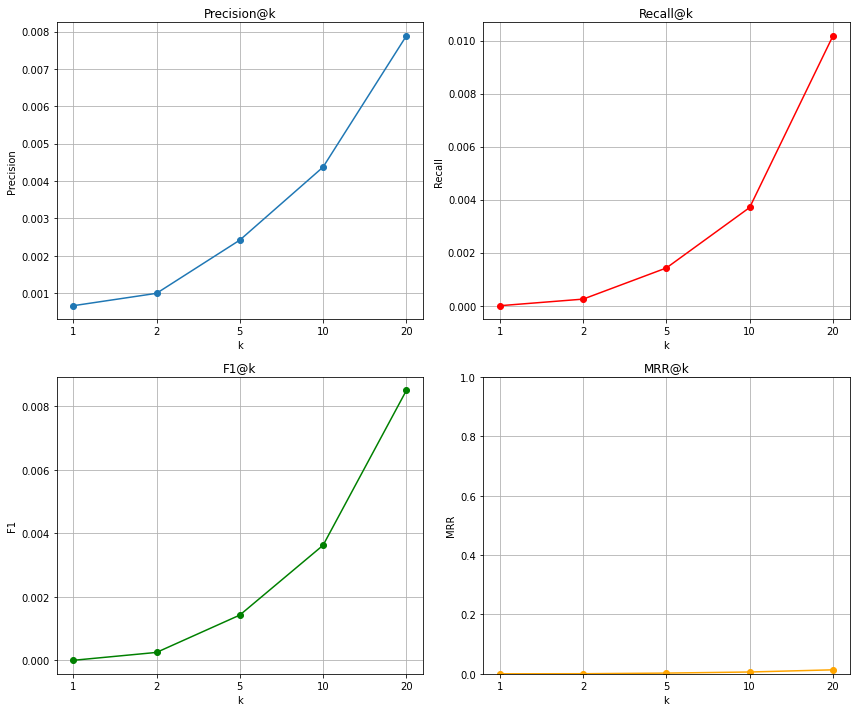

In [74]:
# from metrics import EvaluationMetrics
# metrics = EvaluationMetrics1(top_k_items_popularity, top_k_items_gt)
metrics = EvaluationMetrics1(top_k_items, top_k_items_gt)
k = 10

# Single k evaluation
avg_precision, avg_recall, avg_f1, avg_mrr = metrics.evaluate_at_k(k)
print(f"Average Precision@{k}: {avg_precision}")
print(f"Average Recall@{k}: {avg_recall}")
print(f"Average F1@{k}: {avg_f1}")
print(f"Average MRR: {avg_mrr}")

# Multiple k evaluation and plotting
ks = [1, 2, 5, 10,20]
metrics.plot_metrics(ks)

In [ ]:
train_data, test_data, eval_data = python_stratified_split(ratings_final, ratio=[0.6, 0.2, 0.2], col_user='user_index', col_item='item', seed=12)
n_entity, n_relation, kg = load_kg(kg_final)
print("Number of entities:", n_entity)
print("Number of relations:", n_relation)

In [ ]:
user_history_dict = train_data.loc[train_data.rating == 1].groupby('user_index')['item'].apply(list).to_dict()
n_hop = 3
n_memory = 32
ripple_set = get_ripple_set(kg, user_history_dict, n_hop=n_hop, n_memory=n_memory)
ripple_set[0]

In [75]:
with Timer() as train_time:
    ripple.fit(n_epoch=n_epoch, batch_size=batch_size,save_path='./',
               train_data=train_data[["user_index", "item", "rating"]], 
               ripple_set=ripple_set,
               show_loss=show_loss)

print("Took {} seconds for training.".format(train_time.interval))

Model saved to .//model_epoch_1.ckpt
Model saved to .//model_epoch_2.ckpt
Model saved to .//model_epoch_3.ckpt
Model saved to .//model_epoch_4.ckpt
Model saved to .//model_epoch_5.ckpt
Model saved to .//model_epoch_6.ckpt
Model saved to .//model_epoch_7.ckpt
Model saved to .//model_epoch_8.ckpt
Model saved to .//model_epoch_9.ckpt
Model saved to .//model_epoch_10.ckpt
Took 5063.4386552 seconds for training.


In [76]:
with Timer() as test_time:
    labels, scores = ripple.predict(batch_size=batch_size, ripple_set=ripple_set,
                                    data=test_data[["user_index", "item", "rating"]])
    predictions = [1 if i >= 0.5 else 0 for i in scores]

test_data['scores'] = scores
print("Took {} seconds for prediction.".format(test_time.interval))

Took 21.138274799999635 seconds for prediction.


In [77]:
acc_score = np.mean(np.equal(predictions, labels)) # same result as in sklearn.metrics.accuracy_score 
print("The accuracy is {}".format(acc_score))

The accuracy is 0.7243747719285968


In [78]:
from itertools import product


from tqdm import tqdm
cartesian_cross = tqdm(
    product(test_data["user_index"].unique().tolist(), test_data["item"].unique().tolist()),
    total=test_data["item"].nunique() * test_data["user_index"].nunique()
)

all_user_item_pairs = pd.DataFrame(cartesian_cross,columns=["user_index","item"])
# eval_data#["user_index"].nunique()



100%|██████████| 20957898/20957898 [00:06<00:00, 3323071.78it/s]


In [79]:
merged_df = pd.merge(all_user_item_pairs, test_data, on=['user_index', 'item'], how='left')

# Replace NaN values with 0
merged_df.fillna(0, inplace=True)

In [80]:
with Timer() as test_time:
    labels, scores = ripple.predict(batch_size=batch_size, ripple_set=ripple_set,
                                    data=merged_df[["user_index", "item", "rating"]])
    predictions = [1 if i >= 0.5 else 0 for i in scores]

merged_df['scores'] = scores
print("Took {} seconds for prediction.".format(test_time.interval))

Took 1999.987899300002 seconds for prediction.


In [81]:
with Timer() as topk_time:
    top_k_items = ripple.recommend_k_items(batch_size=batch_size, train_data=train_data,
                                        data=merged_df[["user_index", "item", "rating", "original_rating"]],
                                        top_k=20, remove_seen=remove_seen)
print("Took {} seconds for top_k_items.".format(topk_time.interval))

Took 2011.3935414000007 seconds for top_k_items.


In [82]:
precision_k_score = precision_at_k(test_data, top_k_items, 
            col_user="user_index",
            col_item="item",
            col_rating="original_rating",
            col_prediction="scores",
            relevancy_method="top_k",
            k=TOP_K)
print("The precision_k_score score at k = {}, is {}".format(TOP_K, precision_k_score))

The precision_k_score score at k = 10, is 0.002633322292149718


Average Precision@10: 0.00182179529645578
Average Recall@10: 0.0016237112046982864
Average F1@10: 0.0015216153347667179
Average MRR: 0.0027035783950325187


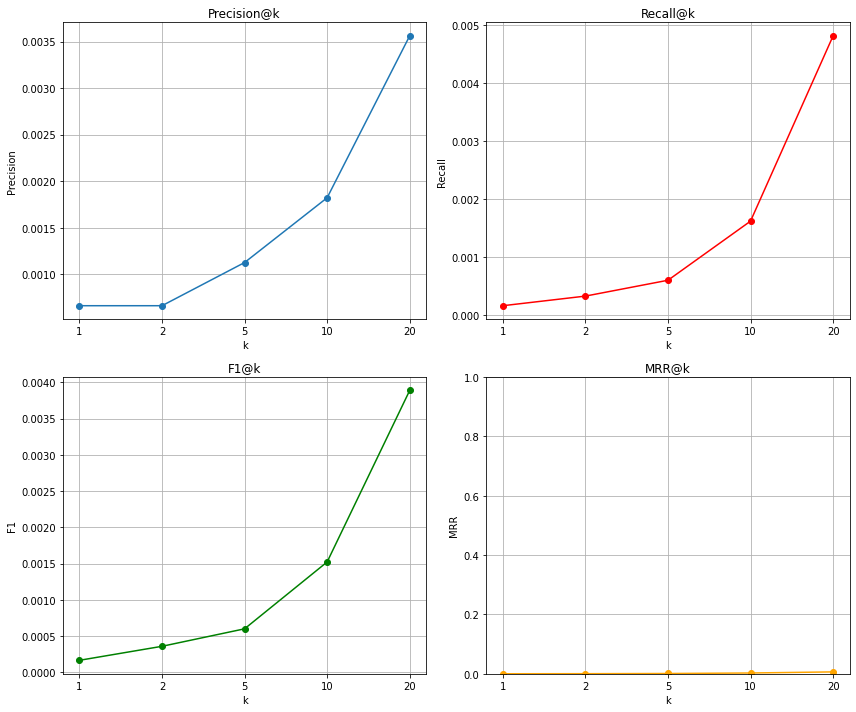

In [83]:
# from metrics import EvaluationMetrics
# metrics = EvaluationMetrics1(top_k_items_popularity, top_k_items_gt)
metrics = EvaluationMetrics1(top_k_items, top_k_items_gt)
k = 10

# Single k evaluation
avg_precision, avg_recall, avg_f1, avg_mrr = metrics.evaluate_at_k(k)
print(f"Average Precision@{k}: {avg_precision}")
print(f"Average Recall@{k}: {avg_recall}")
print(f"Average F1@{k}: {avg_f1}")
print(f"Average MRR: {avg_mrr}")

# Multiple k evaluation and plotting
ks = [1, 2, 5, 10,20]
metrics.plot_metrics(ks)

In [84]:
train_data, test_data, eval_data = python_stratified_split(ratings_prunning, ratio=[0.6, 0.2, 0.2], col_user='user_index', col_item='item', seed=12)
n_entity, n_relation, kg = load_kg(kg_prunning)
print("Number of entities:", n_entity)
print("Number of relations:", n_relation)
user_history_dict = train_data.loc[train_data.rating == 1].groupby('user_index')['item'].apply(list).to_dict()
n_hop = 3
n_memory = 32
ripple_set = get_ripple_set(kg, user_history_dict, n_hop=n_hop, n_memory=n_memory)

Number of entities: 506199
Number of relations: 506199


In [85]:
ripple_set[0]


[([177731,
   60938,
   65540,
   17451,
   47243,
   72448,
   16889,
   104547,
   24304,
   3654,
   94449,
   122681,
   44309,
   19845,
   64904,
   102145,
   92176,
   3103,
   35446,
   46125,
   126142,
   22524,
   137158,
   62580,
   163702,
   49029,
   22572,
   60938,
   22572,
   68495,
   137158,
   27143],
  [22,
   20,
   7,
   5,
   2,
   22,
   2,
   20,
   6,
   4,
   20,
   2,
   2,
   2,
   22,
   2,
   2,
   7,
   2,
   22,
   20,
   2,
   22,
   2,
   22,
   8,
   22,
   8,
   2,
   2,
   23,
   2],
  [7195,
   44682,
   205308,
   32628,
   112230,
   7751,
   455161,
   10924,
   36031,
   8102,
   12626,
   160198,
   90514,
   63046,
   9954,
   111120,
   108707,
   245528,
   93912,
   9239,
   47893,
   91495,
   7195,
   191633,
   6571,
   479031,
   6571,
   94354,
   91128,
   171213,
   32602,
   466854]),
 ([6571,
   6571,
   7195,
   6571,
   7195,
   6571,
   7195,
   6571,
   6571,
   6571,
   7195,
   6571,
   7195,
   6571,
   6571,
   7751,

In [86]:
with Timer() as train_time:
    ripple.fit(n_epoch=n_epoch, batch_size=batch_size,save_path='./',
               train_data=train_data[["user_index", "item", "rating"]], 
               ripple_set=ripple_set,
               show_loss=show_loss)

print("Took {} seconds for training.".format(train_time.interval))

InvalidArgumentError: indices[15] = 344648 is not in [0, 182011)
	 [[node embedding_lookup (defined at d:\yu\nwo\recommenders-ripplenet\reco_utils\recommender\ripplenet\model.py:142)  = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_DOUBLE, _class=["loc:@Adam/Assign_1"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](entity_emb_matrix/read, _arg_items_0_0, embedding_lookup/axis)]]

Caused by op 'embedding_lookup', defined at:
  File "d:\conda\envs\LSTF\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "d:\conda\envs\LSTF\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "d:\conda\envs\LSTF\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "d:\conda\envs\LSTF\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "d:\conda\envs\LSTF\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "d:\conda\envs\LSTF\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "d:\conda\envs\LSTF\lib\asyncio\base_events.py", line 442, in run_forever
    self._run_once()
  File "d:\conda\envs\LSTF\lib\asyncio\base_events.py", line 1462, in _run_once
    handle._run()
  File "d:\conda\envs\LSTF\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "d:\conda\envs\LSTF\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "d:\conda\envs\LSTF\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
    ret = callback()
  File "d:\conda\envs\LSTF\lib\site-packages\tornado\gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "d:\conda\envs\LSTF\lib\site-packages\tornado\gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "d:\conda\envs\LSTF\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "d:\conda\envs\LSTF\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "d:\conda\envs\LSTF\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "d:\conda\envs\LSTF\lib\site-packages\tornado\gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "d:\conda\envs\LSTF\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "d:\conda\envs\LSTF\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "d:\conda\envs\LSTF\lib\site-packages\tornado\gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "d:\conda\envs\LSTF\lib\site-packages\ipykernel\kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "d:\conda\envs\LSTF\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "d:\conda\envs\LSTF\lib\site-packages\tornado\gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "d:\conda\envs\LSTF\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "d:\conda\envs\LSTF\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "d:\conda\envs\LSTF\lib\site-packages\IPython\core\interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "d:\conda\envs\LSTF\lib\site-packages\IPython\core\interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "d:\conda\envs\LSTF\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "d:\conda\envs\LSTF\lib\site-packages\IPython\core\interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "d:\conda\envs\LSTF\lib\site-packages\IPython\core\interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "d:\conda\envs\LSTF\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-6042958fa395>", line 12, in <module>
    seed=seed)
  File "d:\yu\nwo\recommenders-ripplenet\reco_utils\recommender\ripplenet\model.py", line 75, in __init__
    self._build_model()
  File "d:\yu\nwo\recommenders-ripplenet\reco_utils\recommender\ripplenet\model.py", line 142, in _build_model
    self.entity_emb_matrix, self.items
  File "d:\conda\envs\LSTF\lib\site-packages\tensorflow\python\ops\embedding_ops.py", line 313, in embedding_lookup
    transform_fn=None)
  File "d:\conda\envs\LSTF\lib\site-packages\tensorflow\python\ops\embedding_ops.py", line 133, in _embedding_lookup_and_transform
    result = _clip(array_ops.gather(params[0], ids, name=name),
  File "d:\conda\envs\LSTF\lib\site-packages\tensorflow\python\ops\array_ops.py", line 2675, in gather
    return gen_array_ops.gather_v2(params, indices, axis, name=name)
  File "d:\conda\envs\LSTF\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3976, in gather_v2
    "GatherV2", params=params, indices=indices, axis=axis, name=name)
  File "d:\conda\envs\LSTF\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "d:\conda\envs\LSTF\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "d:\conda\envs\LSTF\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "d:\conda\envs\LSTF\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): indices[15] = 344648 is not in [0, 182011)
	 [[node embedding_lookup (defined at d:\yu\nwo\recommenders-ripplenet\reco_utils\recommender\ripplenet\model.py:142)  = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_DOUBLE, _class=["loc:@Adam/Assign_1"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](entity_emb_matrix/read, _arg_items_0_0, embedding_lookup/axis)]]


In [ ]:
with Timer() as test_time:
    labels, scores = ripple.predict(batch_size=batch_size, ripple_set=ripple_set,
                                    data=test_data[["user_index", "item", "rating"]])
    predictions = [1 if i >= 0.5 else 0 for i in scores]

test_data['scores'] = scores
print("Took {} seconds for prediction.".format(test_time.interval))

In [ ]:
acc_score = np.mean(np.equal(predictions, labels)) # same result as in sklearn.metrics.accuracy_score 
print("The accuracy is {}".format(acc_score))

In [ ]:
from itertools import product


from tqdm import tqdm
cartesian_cross = tqdm(
    product(test_data["user_index"].unique().tolist(), test_data["item"].unique().tolist()),
    total=test_data["item"].nunique() * test_data["user_index"].nunique()
)

all_user_item_pairs = pd.DataFrame(cartesian_cross,columns=["user_index","item"])



In [ ]:
merged_df = pd.merge(all_user_item_pairs, test_data, on=['user_index', 'item'], how='left')

# Replace NaN values with 0
merged_df.fillna(0, inplace=True)

In [ ]:
with Timer() as test_time:
    labels, scores = ripple.predict(batch_size=batch_size, ripple_set=ripple_set,
                                    data=merged_df[["user_index", "item", "rating"]])
    predictions = [1 if i >= 0.5 else 0 for i in scores]

merged_df['scores'] = scores
print("Took {} seconds for prediction.".format(test_time.interval))

In [ ]:
with Timer() as topk_time:
    top_k_items = ripple.recommend_k_items(batch_size=batch_size, train_data=train_data,
                                        data=merged_df[["user_index", "item", "rating", "original_rating"]],
                                        top_k=20, remove_seen=remove_seen)
print("Took {} seconds for top_k_items.".format(topk_time.interval))

In [ ]:
precision_k_score = precision_at_k(test_data, top_k_items, 
            col_user="user_index",
            col_item="item",
            col_rating="original_rating",
            col_prediction="scores",
            relevancy_method="top_k",
            k=TOP_K)
print("The precision_k_score score at k = {}, is {}".format(TOP_K, precision_k_score))

In [ ]:
# from metrics import EvaluationMetrics
# metrics = EvaluationMetrics1(top_k_items_popularity, top_k_items_gt)
metrics = EvaluationMetrics1(top_k_items, top_k_items_gt)
k = 10

# Single k evaluation
avg_precision, avg_recall, avg_f1, avg_mrr = metrics.evaluate_at_k(k)
print(f"Average Precision@{k}: {avg_precision}")
print(f"Average Recall@{k}: {avg_recall}")
print(f"Average F1@{k}: {avg_f1}")
print(f"Average MRR: {avg_mrr}")

# Multiple k evaluation and plotting
ks = [1, 2, 5, 10,20]
metrics.plot_metrics(ks)

# Baselines

In [ ]:
movie_stats = ratings_final.groupby('item').agg(
    rating_count=('original_rating', 'size'),
    avg_rating=('original_rating', 'mean')
).reset_index()

# Step 2: Filter movies with avg_rating > 3
popular_movies = movie_stats[movie_stats['avg_rating'] > 3]

# Step 3: Sort movies by rating_count and avg_rating
popular_movies = popular_movies.sort_values(by=['rating_count', 'avg_rating'], ascending=[False, False])

# Step 4: Select top K popular movies
K = 100  # Set K as required
top_k_popular_movies = popular_movies.head(K)

# Step 5: Assign rank based on the sorted order
top_k_popular_movies['rank'] = range(1, len(top_k_popular_movies) + 1)

# Step 6: Create the assignment of top K popular movies to each user
users = test_data['user_index'].unique()
top_k_items_popularity = pd.DataFrame({
    'user_index': users.repeat(K),
    'item': list(top_k_popular_movies['item']) * len(users),
    'avg_rating': list(top_k_popular_movies['avg_rating']) * len(users),
    'rank': list(top_k_popular_movies['rank']) * len(users)
})
top_k_items_popularity['scores'] = top_k_items_popularity['avg_rating']

d:\conda\envs\LSTF\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Average Precision@10: 0.06466809421841542
Average Recall@10: 0.056242989701233814
Average F1@10: 0.056374639982478714
Average MRR: 0.12591218857278813


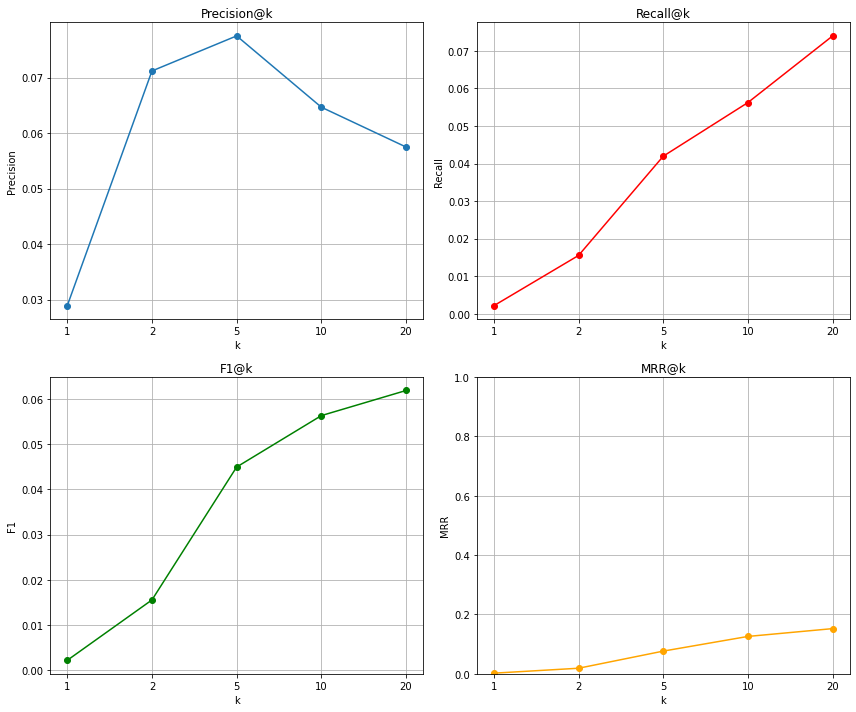

In [ ]:
# from metrics import EvaluationMetrics
# metrics = EvaluationMetrics1(top_k_items_popularity, top_k_items_gt)
metrics = EvaluationMetrics1(top_k_items_popularity, top_k_items_gt)
k = 10

# Single k evaluation
avg_precision, avg_recall, avg_f1, avg_mrr = metrics.evaluate_at_k(k)
print(f"Average Precision@{k}: {avg_precision}")
print(f"Average Recall@{k}: {avg_recall}")
print(f"Average F1@{k}: {avg_f1}")
print(f"Average MRR: {avg_mrr}")

# Multiple k evaluation and plotting
ks = [1, 2, 5, 10,20]
metrics.plot_metrics(ks)